# **5.3 Density Estimation**

## 5.3.1. Gaussian Mixture Models

The *k*-means clustering model explored in the previous sessions is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the nonprobabilistic nature of *k*-means and its use of simple distance from cluster center to assign cluster membership leads to poor performance for many real-world situations.
Now, we will take a look at mixture models, in particular Gaussian, which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.


In [43]:
import matplotlib.pyplot as plt
import numpy as np

**Weaknesses of k-Means**

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous chapter, given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [44]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

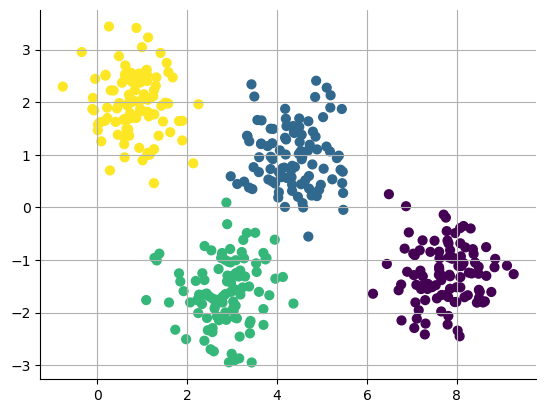

In [45]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, n_init=10, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.grid()

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assignment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hypersphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function (see the following figure):

In [46]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, ec='black', fc='lightgray',
                                lw=3, alpha=0.5, zorder=1))

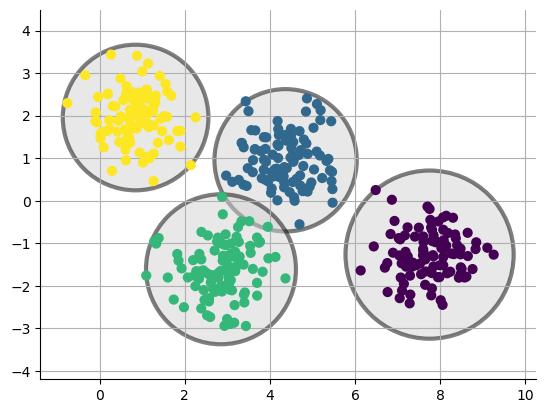

In [47]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
plot_kmeans(kmeans, X)
plt.grid()

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled, as you can see in the following figure:

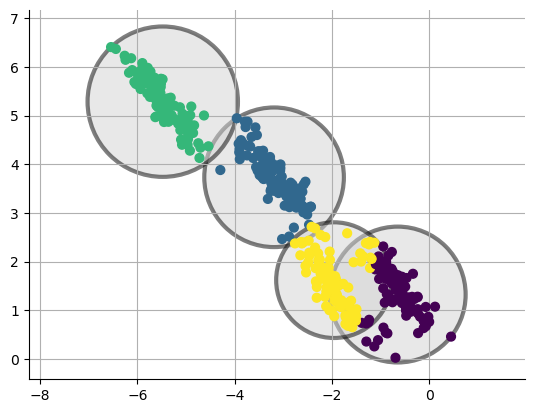

In [48]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, n_init=10, random_state=0)
plot_kmeans(kmeans, X_stretched)
plt.grid()

By eye, we recognize that these transformed clusters are noncircular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guarantee that such a global operation will circularize the individual groups.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for noncircular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

**Gaussian Mixture Models**

One way to create more complex probability models is to take a convex combination of simple distributions. This is called a **mixture model**. This has the form: 

$$p(y | \theta) = \sum_{k=1}^{K} \pi_{k} p_{k}(y)$$

where $p_{k}$ is the k'th mixture component and $\pi_{k}$ are the mixture weights which satisty $0 \leq \pi_{k} \leq 1$ and $\sum_{k=1}^{K} \pi_{k} = 1$.

A Gaussian mixture model or GMM, is defined as follows: 

$$p(y|\theta) = \sum_{k=1}^{K} \pi_{k}\mathcal{N}(y | \mu_{k}, \Sigma_{k})$$

and it represents a mixture of multidimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means (see the following figure):

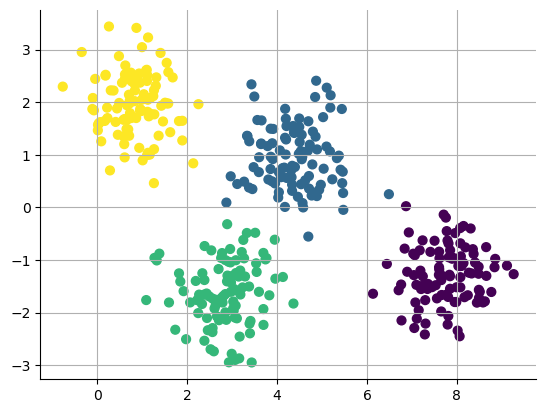

In [49]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
plt.grid()

But because a GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the `predict_proba` method.
This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [50]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

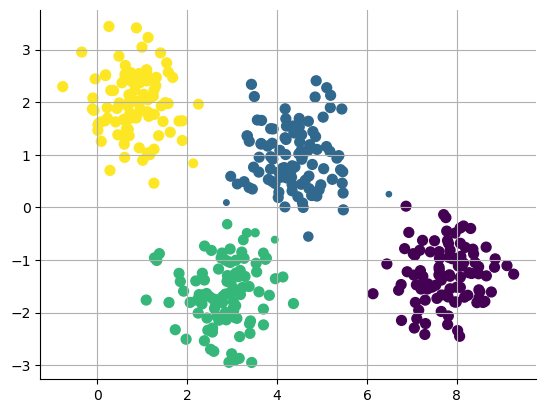

In [51]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);
plt.grid()

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach, which qualitatively does the following:

1. Choose starting guesses for the location and shape.

2. Repeat until converged:

   1. *E-step*: For each point, find weights encoding the probability of membership in each cluster.
   2. *M-step*: For each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights.

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [52]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        ax = ax or plt.gca()
    
        # Convert covariance to principal axes
        if covar.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covar)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            w, h = 2 * np.sqrt(s)
        else:
            angle = 0
            w, h = 2 * np.sqrt(covar)
        
        ax.add_patch(Ellipse(pos, width=2*w,  height=2*h, angle=angle, edgecolor='r', fc='None', lw=1))

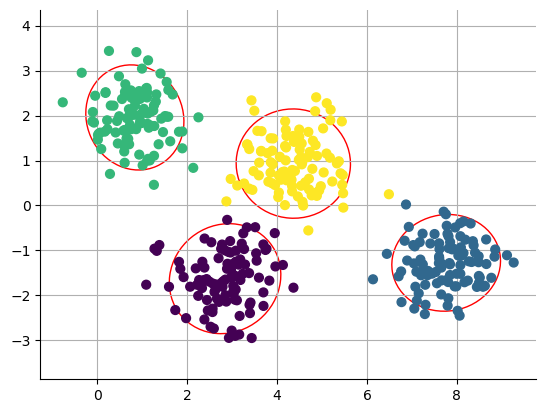

In [53]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)
plt.grid()

With this in place, we can take a look at what the four-component GMM gives us for our initial data (see the following figure):

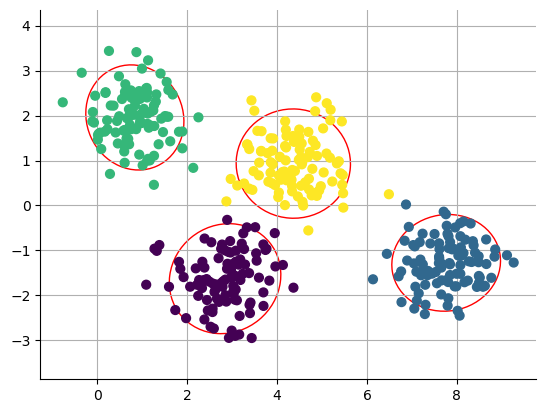

In [54]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)
plt.grid()

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters, as we can see in the following figure:

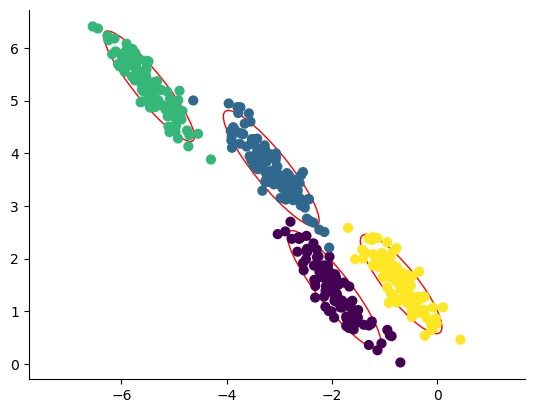

In [55]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMMs address the two main practical issues with *k*-means encountered before.

A simple example of how convex combination, or weighted average works, of the PDFs of the component distributions is this: 

Consider two gaussians with different mean and covariance. We will consider the weighted average of them such that:

$$p(x) = 0.7 \mathcal{N}(3,1)+0.3 \mathcal{N}(6,2)$$

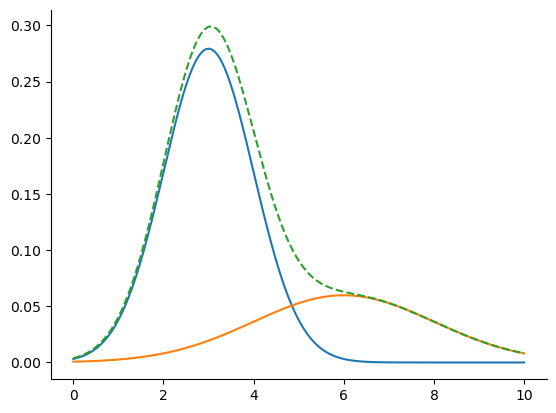

In [56]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# define your distributions
d1 = stats.norm(3, 1)
d2 = stats.norm(6, 2)

# set mixture component weights
mc = [0.7, 0.3]
mc = mc / np.sum(mc) # ensuring they sum to 1

# where to evaluate the densities
x = np.linspace(0, 10, 501)
# calculate density and apply mixture weights
c1 = d1.pdf(x) * mc[0]
c2 = d2.pdf(x) * mc[1]

# plot everything
plt.plot(x, c1, label='Component 1')
plt.plot(x, c2, label='Component 2')
plt.plot(x, c1 + c2, '--', label='Mixture')

A Gaussian mixture model is a soft clustering technique used in unsupervised learning to determine the probability that a given data point belongs to a cluster. It’s composed of several Gaussians, each identified by $k \in \{1,…, K\}$, where $K$ is the number of clusters in a data set.

**Choosing the Covariance Type**

If you look at the details of the preceding fits, you will see that the `covariance_type` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is `covariance_type="diag"`, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is `covariance_type="spherical"`, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use `covariance_type="full"`, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

![covariancetypes](https://miro.medium.com/v2/resize:fit:1400/1*DsYoNVJhR0tfmfFhp5rdyw.png)

**Gaussian Mixture Models as Density Estimation**

Though the GMM might be often thought of as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data as we said.

As an example, consider some data generated from Scikit-Learn's `make_moons` function again: 

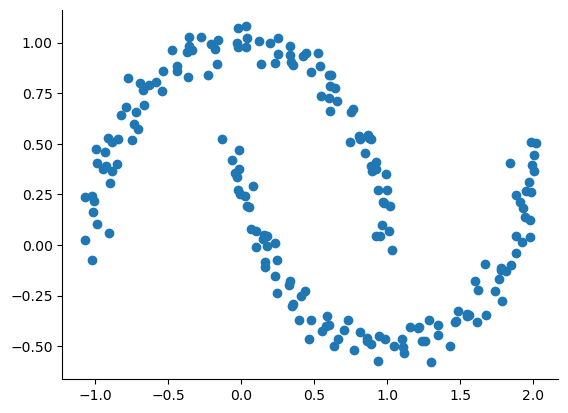

In [57]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

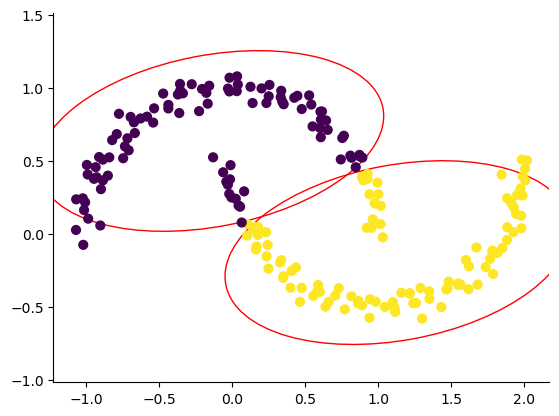

In [58]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

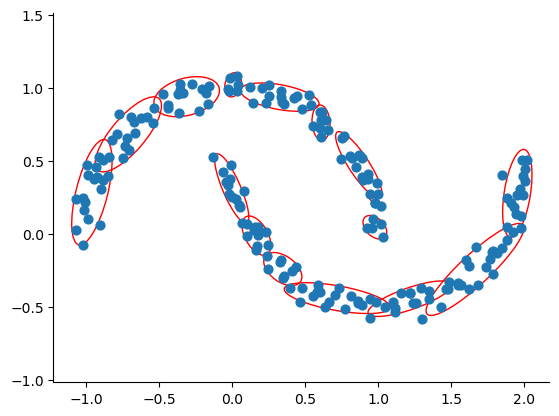

In [59]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussian components serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

Text(0.5, 1.0, 'New generated points from GMM')

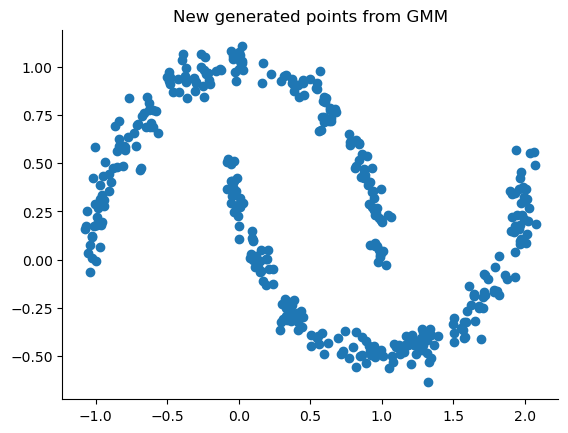

In [60]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);
plt.title('New generated points from GMM')

Therefore, a GMM is very powerful means of modeling an arbitrary multidimensional distribution of data as well as a generation of data tool.

**How many components?**

The fact that a GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid overfitting.
Another means of correcting for overfitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's `GaussianMixture` estimator actually includes built-in methods that compute both of these, so it is very easy to operate using this approach.

Let's look at the AIC and BIC versus the number of GMM components for our moons dataset (see the following figure):

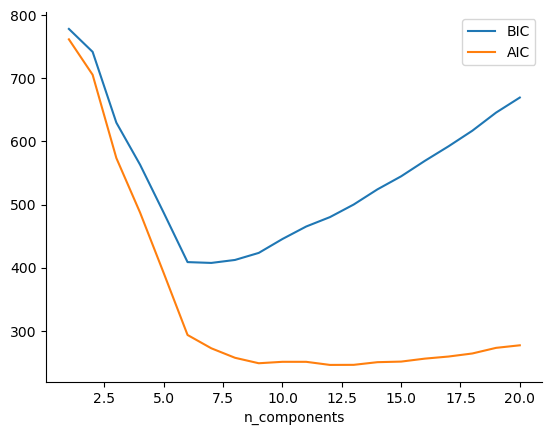

In [61]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components earlier was probably too many: around 8–12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well a GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of the GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

**Example: GMMs for Generating New Data**

We just saw a simple example of using a GMM as a generative model in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [62]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next, let's plot the first 50 of these to recall exactly what we're looking at (see the following figure):

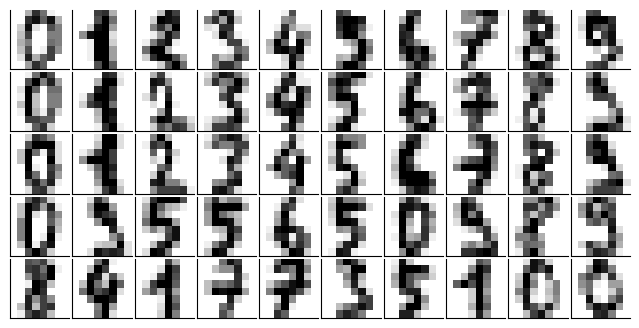

In [63]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(8, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high-dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [64]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

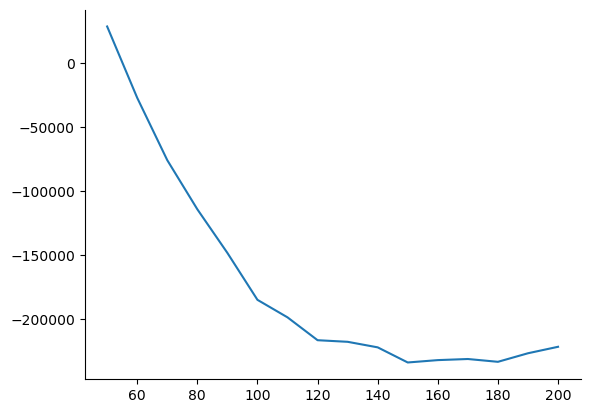

In [65]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 140 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [66]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [67]:
data_new, label_new = gmm.sample(100)
data_new.shape

(100, 41)

Finally, we can use the inverse transform of the PCA object to construct the new digits (see the following figure):

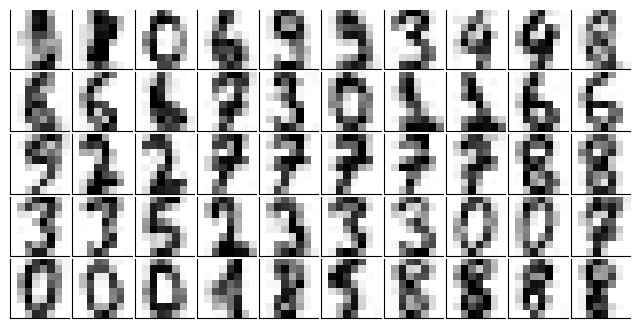

In [68]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits," which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.

## 5.3.2. Kernel Density Estimation

In this section, we consider a form of non-parametric density estimation known as kernel density estimation or KDE. This is a form of generative model, since it defines a probability distribution p(x) that can be evaluated pointwise, and which can be sampled from to generate new data.

A density estimator is an algorithm which seeks to model the probability distribution that generated a dataset, as we saw with mixture models. You are already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

Before explaining KDE, we must define what we mena by a 'kernel'. This term has several differente meanings in machine learning and statistics. For this class, we use a specific kind of kernel which we refer to as a **density kernel**. This is a function $\mathcal{K}: \mathbb{R} \mapsto \mathbb{R^{+}}$ such that $\int \mathcal{K}(x) dx = 1$ and $\mathcal{K}(-x) = \mathcal{K}(x)$. This latter symmetry property implies that $\int x \mathcal{K}(x) dx = 0$, and hence, 

$$ \int x \mathcal{K}(x- x_{n}) dx = x_{n}$$

A simple example of such a kernel is the boxcar kernel, which is the uniform distribution within the unit interval around the origin.

Another example is the **Gaussian kernel**:

$$\mathcal{K}(x) = \frac{1}{(2\pi)^{1/2}} e^{-x^{2}/2}$$

We can control the width of the kernel by introducting a **bandwidth** parameter $h$: 

$$\mathcal{K}_{h} = \frac{1}{h} \mathcal{K}\big(\frac{x}{h}\big)$$

Although Gaussian kernels are popular, they have unbounded support. Some alternative kernels, which have compact supper (which can be computationally faster) are: 

integral is 100.0
integral is 99.99749999999987
integral is 100.00000034560483
integral is 86.76775354750039


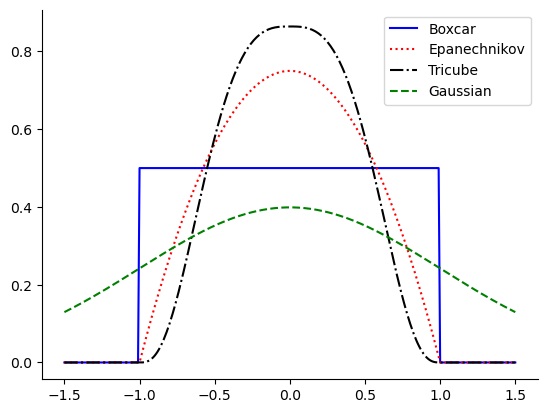

In [69]:
%run 'example_kernels.py'

To explain how we use kernels to define a nonparametric density estimate, recall the form of the Gaussian mixture model. IF we assume a fixed spherical Gaussian covariance and uniform mixture weights, we get: 

$$ p(x | \theta) = \frac{1}{K} \sum_{k=1}^{K} \mathcal{N}(x | \mu_{k}, \sigma^{2}\mathbf{I})$$

one problem with this model is that it requires specifying the number $K$ of clusters, as well as their locations $\mu_{k}$. An alternative to estimating these parameters is to allocate one cluster center per data point. In this case, the model becomes, 

$$p(x | \theta) = \frac{1}{N}\sum_{n=1}^{N} \mathcal{N}(x | x_{n}, \sigma^{2} \mathbf{I})$$

and in fact, we can generalise this equation to all data points using the kernel: 

$$p(x | \mathcal{D}) = \frac{1}{N}\sum_{n=1}^{N} \mathcal{K}_{h}(x - x_{n})$$

where $\mathcal{K}_{h}$ is a density kernel. This is called a **Parzen window density estimator or kernel density estimator (KDE)**. 

The advantage over a parametric model is that no model fitting is required (except for choosig $h$), and there is no need to pick the number of cluster centers. The disadvantage is that the model takes a lor of memory (you need to store all the data) and a lot of time to evaluate.  

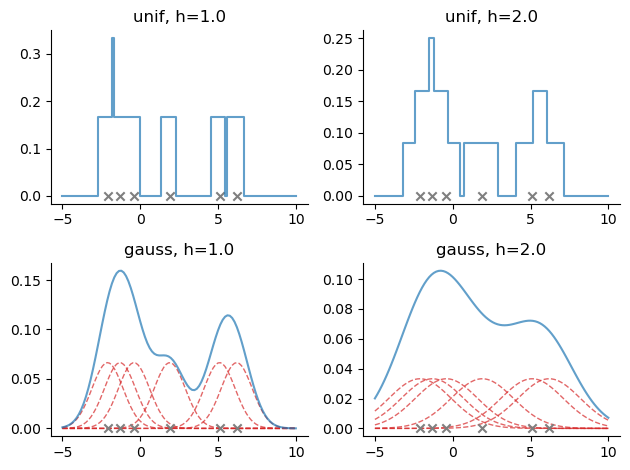

In [70]:
%run 'parzen2.py'